In [1]:
import numpy as np
import random
from scipy.spatial.distance import euclidean
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm


from metric_forest import MetricForest
from metric_tree import MetricTree
from search_algorithms import exact_nn_search, defeatist_search,  search_pruning, search_pruning_in_forest, search_defeatist_in_forest
from search_alg_visited_nodes import defeatist_search_vn, search_pruning_vn, search_defeatist_in_forest_vn, search_pruning_in_forest_vn

# Question 3

In [2]:
def select_random_points(n_points, dim, n):
    points = n*np.random.random((n_points, dim))
    if dim == 2:
        plt.scatter(points[:,0], points[:,1])
        plt.title('Random Selected points to apply the NN Search')
        plt.show()
    elif dim == 3:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(points[:,0], points[:,1], points[:,2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.title('Random Selected points to apply the NN Search')
        plt.show()
    return points

def data_drawn_from_gaussians(n_points, dim, n, num_points_gaussian):
    assert n_points%num_points_gaussian == 0, 'Please choose a number of points multiple of num_points_gaussian'
    all_points = np.zeros((n_points, dim))
    for i in range(1, int(n_points/num_points_gaussian)+1):
        sigma, mu = 3*np.random.rand(1), n*np.random.rand(1)
        points = sigma * np.random.randn(num_points_gaussian,dim) + mu
        all_points[(i-1)*num_points_gaussian : i*num_points_gaussian] = points    
    return all_points

def plotting_gaussians(all_points, dim, n, num_points_gaussian):
    assert dim == 2 or dim == 3, 'Please make sure the dimension is 2 or 3 to plot the data'
    assert n_points%num_points_gaussian == 0, 'Please choose a number of points multiple of num_points_gaussian'

    if dim == 3:
        fig = plt.figure()
        ax = Axes3D(fig)

    for i in range(1, int(n_points/num_points_gaussian)+1):
        points = all_points[(i-1)*num_points_gaussian : i*num_points_gaussian]
        if dim == 2:
            plt.scatter(points[:,0], points[:,1])
            plt.title('Points drawn from a mixture of gaussians')
        elif dim == 3:
            ax.scatter(points[:,0], points[:,1], points[:,2])
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            plt.title('Points drawn from a mixture of gaussians')

def plotting3D(points):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(points[:,0], points[:,1], points[:,2])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.title('Plotting the 3D points')   

In [44]:
def average_nodes_visited_dim(n_points, avg, max_dim, n, m, isgaussian=False):
    vn_pruning = []
    vn_defeatist = []
    for d in tqdm(range(1, max_dim + 1), desc="Computing the average nodes visited according to the dimension"):
        vnp = 0
        vnd = 0
        for i in range(avg):
            query = n*np.random.rand(d)
            if isgaussian:
                points = data_drawn_from_gaussians(n_points, d, n, int(n_points/10))
            else:
                points = n*np.random.random((n_points, d))
            forest = MetricForest(m, points)
            vnp += search_pruning_in_forest_vn(forest, query)[2]
            vnd += search_defeatist_in_forest_vn(forest, query)[2]
        vn_pruning.append(vnp/avg)
        vn_defeatist.append(vnd/avg)
    x = [i for i in range(1, max_dim+1)]
    plt.plot(x, vn_pruning, label='Pruning Search')
    plt.plot(x, vn_defeatist, label='Defeatist Search')
    plt.title('Variations of the average number of visited nodes according to the dimension of the ambient space')
    plt.xlabel('Dimension')
    plt.ylabel('Visited Nodes')
    plt.legend()
    plt.show()

def average_nodes_visited_size(avg, max_num_points, n, m, d, isgaussian=False):
    vn_pruning = []
    vn_defeatist = []
    for num_points in tqdm(range(100, max_num_points + 1, 200), desc="Computing the average nodes visited according to the size of the database"):
        vnp = 0
        vnd = 0
        for i in range(avg):
            query = n*np.random.rand(d)
            if isgaussian:
                points = data_drawn_from_gaussians(num_points, d, n, int(num_points/10))
            else:
                points = n*np.random.random((num_points, d))
            forest = MetricForest(m, points)
            vnp += search_pruning_in_forest_vn(forest, query)[2]
            vnd += search_defeatist_in_forest_vn(forest, query)[2]
        vn_pruning.append(vnp/avg)
        vn_defeatist.append(vnd/avg)
    x = [i for i in range(100, max_num_points + 1, 200)]
    plt.plot(x, vn_pruning, label='Pruning Search')
    plt.plot(x, vn_defeatist, label='Defeatist Search')
    plt.title('Variations of the average number of visited nodes according to the database size in dimension {}'.format(d))
    plt.xlabel('Size of the database')
    plt.xscale('log')
    plt.ylabel('Visited Nodes')
    plt.legend()
    plt.show()

def average_nodes_visited_intrinsic_dim(n_points, dim, num_D, n, avg, isgaussian=False):
    vn_pruning = []
    vn_defeatist = []
    if isgaussian:
        points = data_drawn_from_gaussians(n_points, dim, n, int(n_points/10))
    else:
        points = n*np.random.random((n_points, dim))
    for d in tqdm(range(dim, dim + num_D), desc="Computing the average nodes visited according to the dimension"):
        vnp = 0
        vnd = 0
        for i in range(avg):
            query = n*np.random.rand(d)
            new_points = transforming_the_data_from_d_to_D(points, dim, d)
            forest = MetricForest(m, new_points)
            vnp += search_pruning_in_forest_vn(forest, query)[2]
            vnd += search_defeatist_in_forest_vn(forest, query)[2]
        vn_pruning.append(vnp/avg)
        vn_defeatist.append(vnd/avg)
    x = [i for i in range(dim, dim + num_D)]
    plt.plot(x, vn_pruning, label='Pruning Search')
    plt.plot(x, vn_defeatist, label='Defeatist Search')
    plt.title('Variations of the average number of visited nodes according to the dimension of the ambient space for a given database')
    plt.xlabel('Dimension')
    plt.ylabel('Visited Nodes')
    plt.legend()
    plt.show()

In [4]:
def applying_both_searches(forest, query):
    nn_pruning, min_dist_pruning, vn_pruning = search_pruning_in_forest_vn(forest, query)
    nn_defeatist, min_dist_defeatist, vn_defeatist = search_defeatist_in_forest_vn(forest, query)
    return """Exact search with pruning: NN {}, min_dist {}, visited_nodes: {}
Defeatist search : NN {}, min_dist {}, visited_nodes: {}""".format(
nn_pruning, min_dist_pruning, vn_pruning, nn_defeatist, min_dist_defeatist, vn_defeatist
    )

# Varying the Dimension of the Ambient Space

## Random points in Euclidean Spaces of dimensions 2, 3, ... N

### Dimension 2

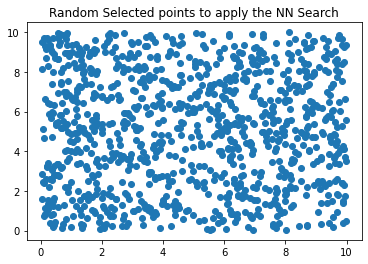

In [5]:
n_points, dim, n = 1000, 2, 10
np.random.seed(42)
points = select_random_points(n_points, dim, n)

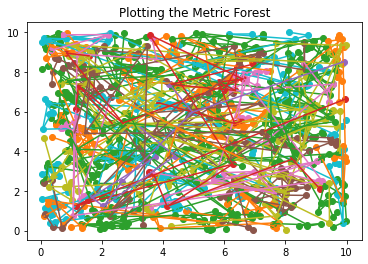

In [6]:
forest = MetricForest(0.5, points)
forest.plot(points)

In [7]:
query = np.random.rand(2)

In [8]:
print(applying_both_searches(forest, query))

Exact search with pruning: NN [0.75863328 1.28879722], min_dist 0.3057457238041049, visited_nodes: 263
Defeatist search : NN [0.75863328 1.28879722], min_dist 0.3057457238041049, visited_nodes: 65


### Dimension 3

In [9]:
query = np.random.rand(3)

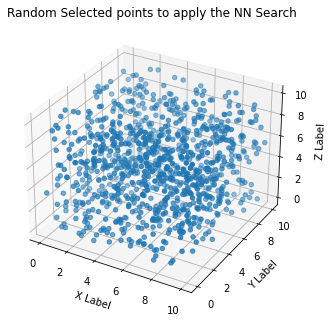

In [10]:
n_points, dim, n = 1000, 3, 10
np.random.seed(42)
points = select_random_points(n_points, dim, n)

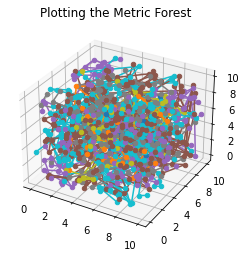

In [11]:
forest = MetricForest(0.5, points)
forest.plot(points)

In [12]:
print(applying_both_searches(forest, query))

Exact search with pruning: NN [0.72084336 0.71256728 0.12108475], min_dist 0.4235608559538375, visited_nodes: 317
Defeatist search : NN [0.72084336 0.71256728 0.12108475], min_dist 0.4235608559538375, visited_nodes: 62


### Dimnesion N

In [13]:
N = 10
points = select_random_points(n_points, N, n)

In [14]:
query = n*np.random.rand(N)
forest = MetricForest(0.5, points)

In [15]:
print(applying_both_searches(forest, query))

Exact search with pruning: NN [3.05432766 7.81256954 3.65919435 2.41602462 6.72200664 1.96758778
 8.9565292  1.05598396 7.06549802 4.99548701], min_dist 4.504337560026525, visited_nodes: 901
Defeatist search : NN [3.05432766 7.81256954 3.65919435 2.41602462 6.72200664 1.96758778
 8.9565292  1.05598396 7.06549802 4.99548701], min_dist 4.504337560026525, visited_nodes: 78


### Visited Nodes according to the variation of the dimension

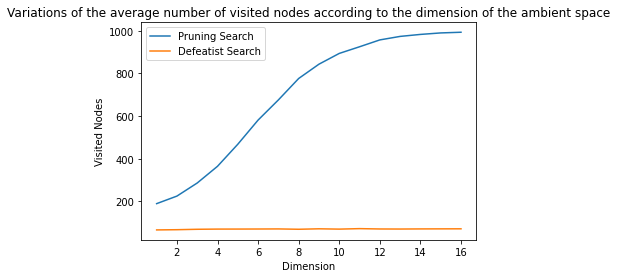

In [16]:
n_points, avg, max_dim, n, m = 1000, 100, 16, 10, 0.5
average_nodes_visited_dim(n_points, avg, max_dim, n, m)

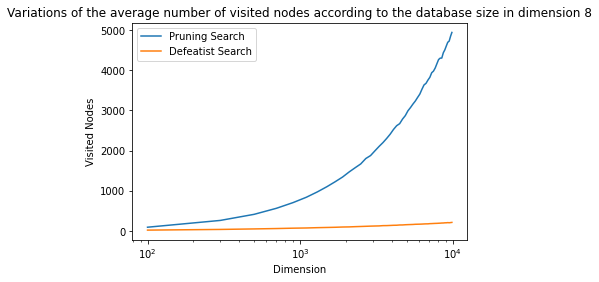

In [17]:
avg, max_num_points, n, m, d = 100, 10000, 10, 0.5, 8
average_nodes_visited_size(avg, max_num_points, n, m, d)

## Random points drawn from a mixture of Gaussians

### Dimension 2

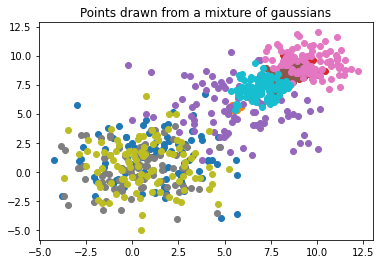

In [18]:
n_points, dim, n, num_points_gaussian = 1000, 2, 10, 100
points = data_drawn_from_gaussians(n_points, dim, n, num_points_gaussian)
plotting_gaussians(points, dim, n, num_points_gaussian)

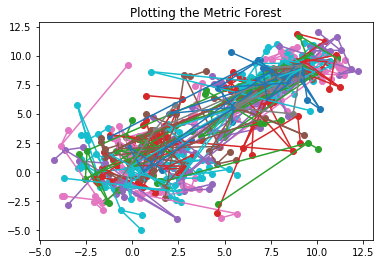

In [20]:
forest = MetricForest(0.5, points)
forest.plot(points)

In [21]:
query = np.random.rand(2)

In [22]:
print(applying_both_searches(forest, query))

Exact search with pruning: NN [0.78087316 0.53163762], min_dist 0.1734173801542548, visited_nodes: 217
Defeatist search : NN [0.78087316 0.53163762], min_dist 0.1734173801542548, visited_nodes: 71


### Dimension 3

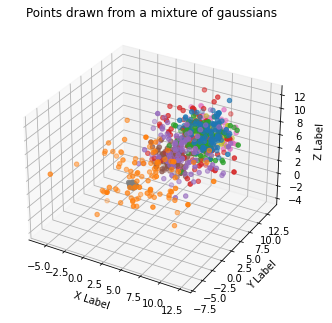

In [23]:
n_points, dim, n, num_points_gaussian = 1000, 3, 10, 100
points = data_drawn_from_gaussians(n_points, dim, n, num_points_gaussian)
plotting_gaussians(points, dim, n, num_points_gaussian)

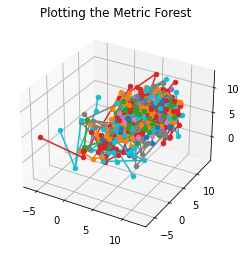

In [24]:
forest = MetricForest(0.5, points)
forest.plot(points)

In [25]:
query = np.random.rand(3)

In [26]:
print(applying_both_searches(forest, query))

Exact search with pruning: NN [ 0.64739848 -0.0815616  -0.816755  ], min_dist 1.1259462232303865, visited_nodes: 331
Defeatist search : NN [ 0.64739848 -0.0815616  -0.816755  ], min_dist 1.1259462232303865, visited_nodes: 61


### Visited Nodes according to the variations of the dimension

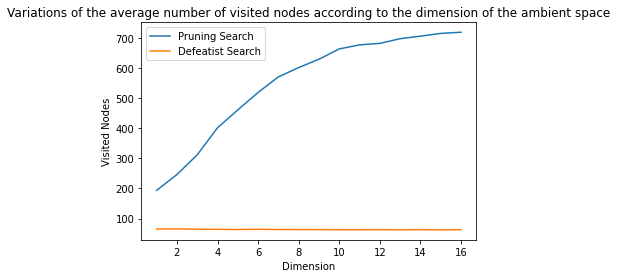

In [27]:
n_points, avg, max_dim, n, m = 1000, 100, 16, 10, 0.5
average_nodes_visited_dim(n_points, avg, max_dim, n, m, isgaussian=True)

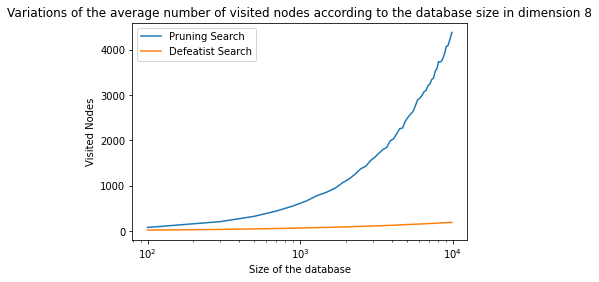

In [45]:
avg, max_num_points, n, m, d = 100, 10000, 10, 0.5, 8
average_nodes_visited_size(avg, max_num_points, n, m, d, isgaussian=True)

# Varying the dimension of the Ambient Space while keeping the intrinsic dimension constant

In [36]:
# intrinsic dimension d
# dimension of the ambient space D

In [37]:
def transforming_the_data_from_d_to_D(points, d, D):
    assert d <= D, 'The dimension of the ambient space must be higher or equal to the instrinsic dimension'
    adding_zeros = np.zeros((points.shape[0], D-d))
    return np.concatenate((points, adding_zeros), axis=1)

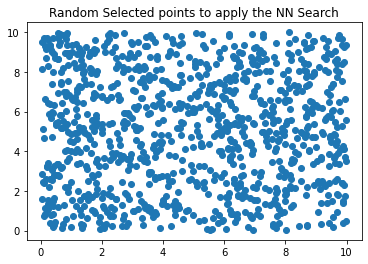

In [38]:
n_points, dim, n = 1000, 2, 10
np.random.seed(42)
points = select_random_points(n_points, dim, n)

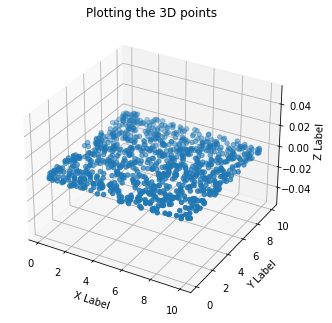

In [39]:
d, D = points.shape[1], 3
new_points = transforming_the_data_from_d_to_D(points, d, D)
plotting3D(new_points)

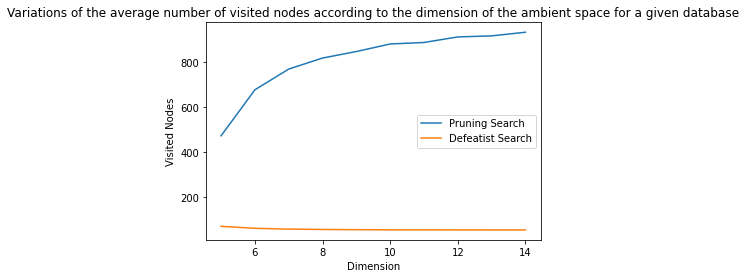

In [40]:
n_points, dim, num_D, n, avg = 1000, 5, 10, 10, 100
average_nodes_visited_intrinsic_dim(n_points, dim, num_D, n, avg)

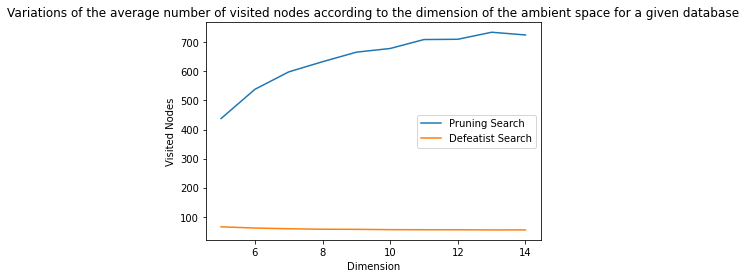

In [41]:
n_points, dim, num_D, n, avg = 1000, 5, 10, 10, 100
average_nodes_visited_intrinsic_dim(n_points, dim, num_D, n, avg, isgaussian=True)